In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
df_clustered = pd.read_csv('../data/Full_data_clustered.csv', sep=',')
X_clustered = pd.read_csv('../data/Clean_feature_clustered.csv', sep=',')

In [34]:
cluster_summary = X_clustered.groupby('cluster').mean().round(2)

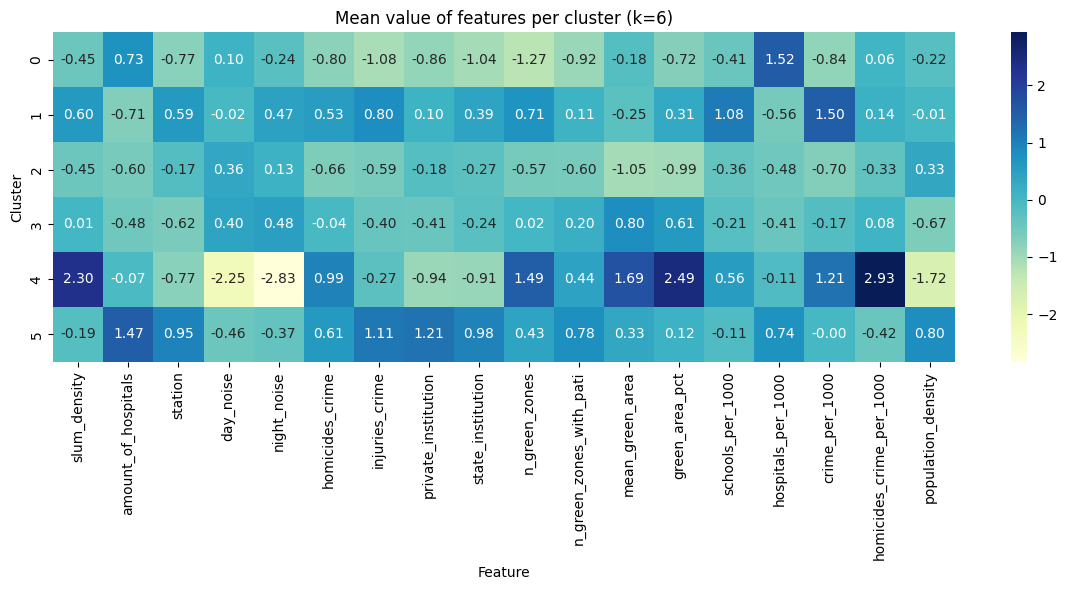

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Mean value of features per cluster (k=6)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

Let's increase the readability of the output

In [39]:
positive_features = [
    'amount_of_hospitals',
    'station',
    'private_institution',
    'state_institution',
    'n_green_zones',
    'n_green_zones_with_pati',
    'mean_green_area',
    'green_area_pct',
    'schools_per_1000',
    'hospitals_per_1000'
]

negative_features = [
    'slum_density',
    'day_noise',
    'night_noise',
    'homicides_crime',
    'injuries_crime',
    'crime_per_1000',
    'homicides_crime_per_1000',
    'population_density'
]

ordered_features = positive_features + negative_features
cluster_summary_ordered = cluster_summary[ordered_features]

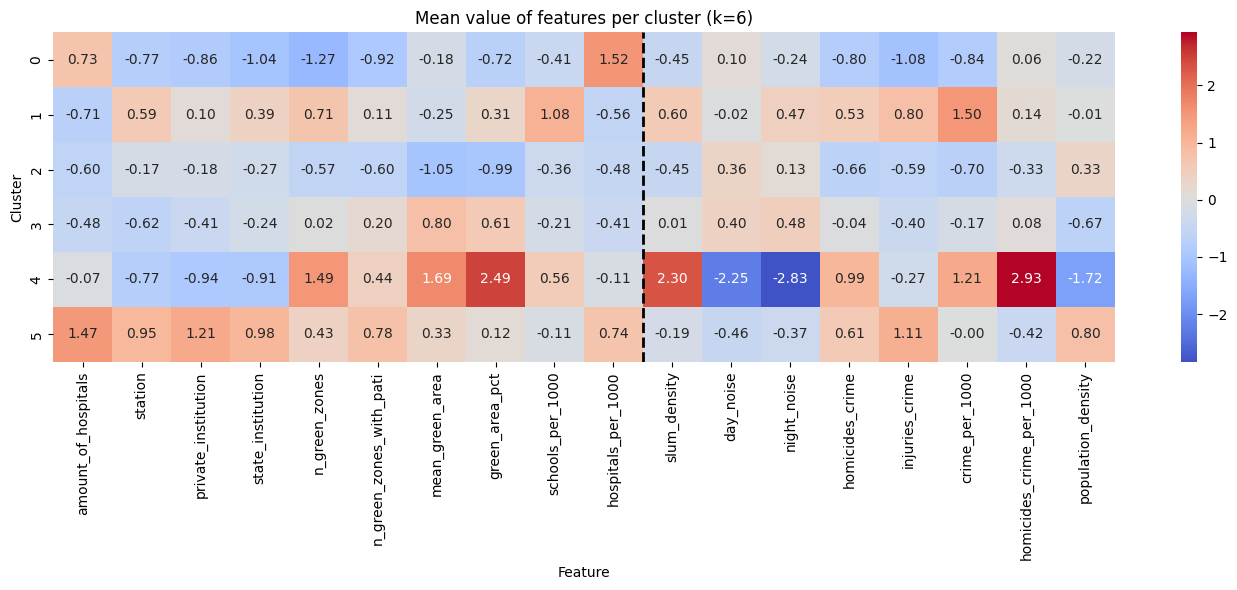

In [40]:
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_summary_ordered, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.axvline(x=len(positive_features), color='black', linestyle='--', lw=2)
plt.title("Mean value of features per cluster (k=6)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

The dotted line separates positive and negative signs.

## Let's start with the visualization on map

In [41]:
import geopandas as gpd
from shapely import wkt

df_clustered['geometry'] = df_clustered['geometry'].apply(wkt.loads)
df_clustered = gpd.GeoDataFrame(df_clustered, geometry='geometry', crs='EPSG:4326')
df_clustered.head(2)

,neighborhood,commune,perimeter_neib,area_neib,geometry,population,slum,amount_of_hospitals,station,day_noise,...,green_area_pct,schools_per_1000,hospitals_per_1000,green_area_per_1000,crime_per_1000,homicides_crime_per_1000,property_crime_per_1000,population_density,slum_density,cluster
0,AGRONOMIA,15,6556.17,2122169.34,"POLYGON ((-58.47589 -34.59172, -58.47598 -34.5...",-1.551111,0.0,-0.710738,-0.767221,-1.141405,...,-1.484560,1.228490,-0.556520,-1.072101,-0.995424,-0.811509,-0.920963,-1.220827,-0.449078,2
1,ALMAGRO,5,8537.90,4050752.25,"POLYGON ((-58.416 -34.59785, -58.41569 -34.597...",1.400821,0.0,0.578137,1.351309,-0.426024,...,-1.411452,-0.034185,-0.233871,-1.831769,-0.399106,-0.503767,-0.264588,2.806393,-0.449078,5


In [42]:
# Colors in hex codes 
cluster_colors = {
0: '#FF0000', # bright red
1: '#654321', # dark brown
2: '#FFFF00', # yellow
3: '#228B22', # deep green
4: '#ADD8E6', # light blue
5: '#0000FF'  # blue
}

In [43]:
df_clustered['color'] = df_clustered['cluster'].map(cluster_colors)

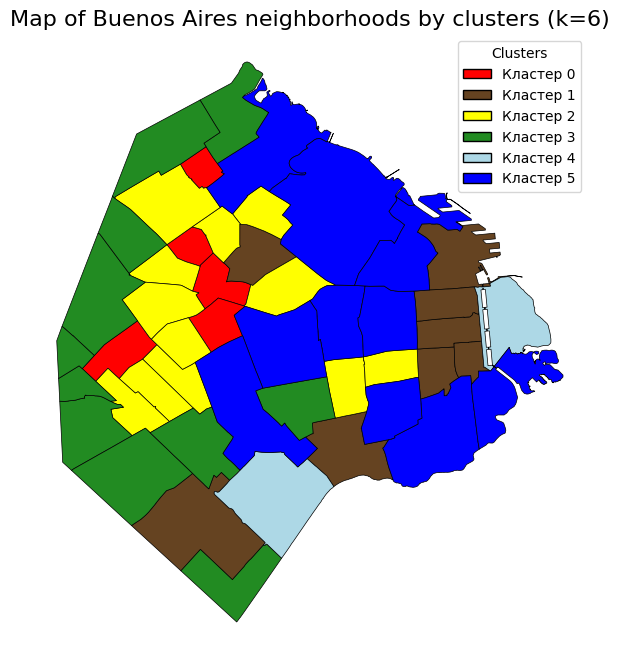

In [45]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=f'Кластер {cluster}')
    for cluster, color in cluster_colors.items()
]

fig, ax = plt.subplots(figsize=(12, 8))

for cluster_id, color in cluster_colors.items():
    df_clustered[df_clustered['cluster'] == cluster_id].plot(
        ax=ax,
        color=color,
        edgecolor='black',
        linewidth=0.5
    )

# Добавим легенду
ax.legend(handles=legend_elements, title='Clusters')
ax.set_title("Map of Buenos Aires neighborhoods by clusters (k=6)", fontsize=16)
ax.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import ace_tools as tools

def label_cluster(metrics):
    if metrics['slum_density'] > 1.5 and metrics['crime_per_1000'] > 2:
        return "Marginalized zone"
    elif metrics['green_area_pct'] > 0.5 and metrics['amount_of_hospitals'] > 1:
        return "Premium urban"
    elif metrics['green_area_pct'] > 0.5:
        return "Green suburban"
    elif metrics['crime_per_1000'] > 0.1 and metrics['slum_density'] > 0.5:
        return "Socially tense"
    elif metrics['green_area_pct'] < -0.8:
        return "Urban core"
    else:
        return "Balanced area"

# Применим функцию к каждому кластеру
cluster_labels = {
    cluster_id: label_cluster(metrics)
    for cluster_id, metrics in df_clustered.items()
}

# Создаем таблицу лейблов
labels_df = pd.DataFrame.from_dict(cluster_labels, orient='index', columns=['Label'])
labels_df.index.name = 'Cluster'

tools.display_dataframe_to_user(name="Cluster Labels", dataframe=labels_df)